# YNet - Dataset 3.1:

Data from Experiment (2), Mitochondria = Cit1-mCherry 

### Importing utilities:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/yeast_v3.1/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO','num1KO', 'mmm1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [5]:
# stats_name = "yeast_v10.2_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
test_ = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val)
test_stats = Statistics.per_class(test_)

working on: datasets\yeast_v3.1\train\01_mfb1KO
working on: datasets\yeast_v3.1\val\01_mfb1KO
working on: datasets\yeast_v3.1\train\01_mmm1KO
working on: datasets\yeast_v3.1\val\01_mmm1KO
working on: datasets\yeast_v3.1\train\01_mmr1KO
working on: datasets\yeast_v3.1\val\01_mmr1KO
working on: datasets\yeast_v3.1\train\01_num1KO
working on: datasets\yeast_v3.1\val\01_num1KO
working on: datasets\yeast_v3.1\train\01_WT
working on: datasets\yeast_v3.1\val\01_WT
working on: datasets\yeast_v3.1\test\02_mfb1KO
working on: datasets\yeast_v3.1\test\02_mmr1KO
working on: datasets\yeast_v3.1\test\02_WT


In [6]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

01_mfb1KO: 	 	 	 (array([0.02111, 0.00453]), array([0.00149, 0.00161]))
01_mmm1KO: 	 	 	 (array([0.02102, 0.00424]), array([0.00149, 0.00183]))
01_mmr1KO: 	 	 	 (array([0.02115, 0.00486]), array([0.00157, 0.00194]))
01_num1KO: 	 	 	 (array([0.02098, 0.005  ]), array([0.00153, 0.00209]))
01_WT: 	 	 	 (array([0.0211, 0.0045]), array([0.00149, 0.00129]))


In [7]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

02_mfb1KO: 	 	 	 (array([0.00794, 0.00483]), array([0.00074, 0.00162]))
02_mmr1KO: 	 	 	 (array([0.00799, 0.00503]), array([0.0008 , 0.00184]))
02_WT: 	 	 	 (array([0.00796, 0.00477]), array([0.00075, 0.00149]))


## Defining datasets:

In [8]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [9]:
def get_data(path: str, sz, bs):
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers=1,
                                                                             test_name='test', test_with_labels=True)
    
    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8)
    
    test_stats_X = {lbl2index_test[key][0]: val for key, val in test_stats.items()}
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    
#     print(main_stats_X)
#     print(test_stats_X)
    
    print('\n class to index mapping:\n',lbl2index)
    print('\n class to index mapping:\n',lbl2index_test)
    return create(tfms)

In [10]:
data = get_data(PATH,SIZE,BATCH_SIZE)


 class to index mapping:
 {'01_WT': [0, 0, 'WT'], '01_mfb1KO': [1, 1, 'mfb1KO'], '01_mmm1KO': [2, 2, 'mmm1KO'], '01_mmr1KO': [3, 3, 'mmr1KO'], '01_num1KO': [4, 4, 'num1KO']}

 class to index mapping:
 {'02_WT': [0, 0, 'WT'], '02_mfb1KO': [1, 1, 'mfb1KO'], '02_mmr1KO': [2, 2, 'mmr1KO']}


In [11]:
x, y = next(iter(data.trn_dl))

In [ ]:
x, y = next(iter(data.test_dl))

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
# print(y)

### Inspect loaded data:

Displaying the same image with and without normalization.

In [ ]:
# specify which image-index
idx = 6

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

# figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2)) # not very elegant atm. 
# figure2.set_size_inches(6,6)
print(yy)

# Training setup

In [12]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

Defining network architecture. 

In [11]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [12]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [13]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [16]:
wd=1e-5 # weight-decay/L2 regularization 

In [17]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 5), data)

In [ ]:
learn.summary()

In [18]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                              
mean: [17.91667 17.91667 25.66667 26.66667  9.41667]
stdev: [4.76897 5.21949 5.37484 5.05525 5.28297]

[WT]: 91.43%
[mfb1KO]:  0.0%
[mmm1KO]: 97.14%
[mmr1KO]:  0.0%
[num1KO]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      20.981655  7.406739   0.377143  
EPOCH 1 ---------------------------------------- STEP 1                                                                                                                                                              
mean: [18.      18.      25.41667 26.75     9.33333]
stdev: [4.6188  4.76095 5.05731 6.15257 2.74874]

[WT]:  0.0%
[mfb1KO]:  0.0%
[mmm1KO]: 97.14%
[mmr1KO]: 80.0%
[num1KO]:  0.0%
    1      16.733855  13.747852  0.354286  
EPOCH 2 ---------------------------------------- STEP 2                       

[array([1.02059]), 0.5142857141154153]

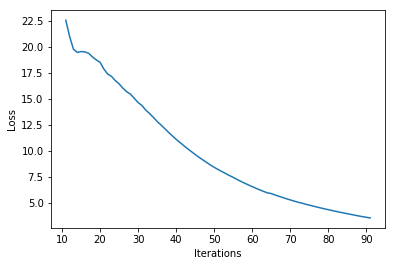

In [19]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

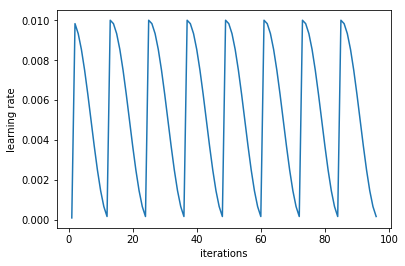

In [20]:
learn.sched.plot_lr()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [21]:
%time learn.fit(1e-2, 10, wds=wd, cycle_len=2, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 8                                                                                                                                                              
mean: [18.08333 18.25    25.08333 26.75     9.41667]
stdev: [5.82321 4.84983 6.52506 5.30919 3.83967]

[WT]: 57.14%
[mfb1KO]: 82.86%
[mmm1KO]: 100.0%
[mmr1KO]: 40.0%
[num1KO]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.912515   1.478739   0.56      
EPOCH 1 ---------------------------------------- STEP 9                                                                                                                                                              
mean: [18.08333 18.16667 25.58333 26.75     9.33333]
stdev: [4.99096 3.99653 3.92552 6.74691 3.03681]

[WT]: 80.0%
[mfb1KO]: 71.43%
[mmm1KO]: 85.71%
[mmr1KO]: 40.0%
[num1KO]: 2.857%
    1      0.859988   0.952781   0.56      
EPOCH 2 ---------------------------------------- STEP 10                   

EPOCH 18 ---------------------------------------- STEP 26                                                                                                                                                            
mean: [18.25    18.      25.5     26.91667  9.16667]
stdev: [5.77531 5.70088 4.48144 3.774   2.79384]

[WT]: 74.29%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 77.14%
[num1KO]: 31.43%
    18     0.603691   0.578558   0.765714  
EPOCH 19 ---------------------------------------- STEP 27                                                                                                                                                            
mean: [18.      18.      25.58333 26.75     9.41667]
stdev: [4.26224 7.68115 3.90424 5.83274 2.75252]

[WT]: 48.57%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 77.14%
[num1KO]: 22.86%
    19     0.592537   0.653949   0.697143  

Wall time: 2min 27s


[array([0.65395]), 0.6971428542477744]

In [22]:
%time learn.fit(1e-3, 3, wds=wd, cycle_len=2, cycle_mult = 2, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 28                                                                                                                                                             
mean: [18.      18.25    25.41667 26.75     9.33333]
stdev: [6.23164 4.14578 4.5909  5.77531 4.28823]

[WT]: 82.86%
[mfb1KO]: 94.29%
[mmm1KO]: 97.14%
[mmr1KO]: 74.29%
[num1KO]: 34.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.532755   0.60096    0.765714  
EPOCH 1 ---------------------------------------- STEP 29                                                                                                                                                             
mean: [18.16667 18.      25.58333 26.5      9.41667]
stdev: [4.13991 2.64575 6.86122 4.59166 3.61613]

[WT]: 88.57%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 68.57%
[num1KO]: 5.714%
    1      0.524037   0.585833   0.725714  
EPOCH 2 ---------------------------------------- STEP 30               

[array([0.63667]), 0.7314285678522927]

In [25]:
wd=5e-5 # weight-decay/L2 regularization 

In [26]:
%time learn.fit(1e-3, 5, wds=wd, cycle_len=3, cycle_mult = 2, use_clr=(20,8, 0.95, 0.85), best_save_name = 'YNet_Res_v3.1')

EPOCH 0 ---------------------------------------- STEP 54                                                                                                                                                             
mean: [17.91667 17.91667 25.25    26.75     9.5    ]
stdev: [5.54464 4.05089 6.86932 9.33742 3.86221]

[WT]: 82.86%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 71.43%
[num1KO]: 17.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.489581   0.537449   0.742857  
EPOCH 1 ---------------------------------------- STEP 55                                                                                                                                                             
mean: [18.25    18.      25.25    26.66667  9.25   ]
stdev: [4.9854  4.63681 5.30919 5.55778 2.08666]

[WT]: 74.29%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 77.14%
[num1KO]: 17.14%
    1      0.475936   0.584851   0.737143  
EPOCH 2 ---------------------------------------- STEP 56               

[num1KO]: 25.71%
    17     0.46562    0.576861   0.742857  
EPOCH 18 ---------------------------------------- STEP 72                                                                                                                                                            
mean: [18.08333 17.83333 25.5     26.91667  9.25   ]
stdev: [3.61613 4.25898 5.51513 3.66193 3.96074]

[WT]: 88.57%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 71.43%
[num1KO]: 14.29%
    18     0.464809   0.533566   0.748571  
EPOCH 19 ---------------------------------------- STEP 73                                                                                                                                                            
mean: [18.16667 18.08333 25.5     26.66667  9.41667]
stdev: [5.44416 3.83967 5.13971 5.80708 3.30299]

[WT]: 88.57%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 77.14%
[num1KO]: 37.14%
    19     0.466224   0.504643   0.805714  
EPOCH 20 ---------------------------------------- STEP 

EPOCH 36 ---------------------------------------- STEP 90                                                                                                                                                            
mean: [18.16667 18.      25.25    26.75     9.41667]
stdev: [4.74049 4.52769 5.29347 4.63906 4.48067]

[WT]: 91.43%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 74.29%
[num1KO]: 22.86%
    36     0.449272   0.563359   0.777143  
EPOCH 37 ---------------------------------------- STEP 91                                                                                                                                                            
mean: [17.91667 17.91667 25.41667 26.58333  9.58333]
stdev: [5.26717 4.36765 5.90844 4.78641 3.59301]

[WT]: 85.71%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 77.14%
[num1KO]: 31.43%
    37     0.446733   0.506123   0.788571  
EPOCH 38 ---------------------------------------- STEP 92                                                           


[WT]: 82.86%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 74.29%
[num1KO]: 28.57%
    54     0.425714   0.509787   0.771429  
EPOCH 55 ---------------------------------------- STEP 109                                                                                                                                                           
mean: [18.16667 17.83333 25.41667 26.83333  9.5    ]
stdev: [3.48409 6.45282 4.85555 4.543   4.38748]

[WT]: 82.86%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 74.29%
[num1KO]: 20.0%
    55     0.423446   0.544216   0.754286  
EPOCH 56 ---------------------------------------- STEP 110                                                                                                                                                           
mean: [18.      18.16667 25.25    26.75     9.41667]
stdev: [4.56435 5.94185 6.60965 6.91767 3.9887 ]

[WT]: 91.43%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 68.57%
[num1KO]: 40.0%
    56     0.423817   0.488602   0.8

EPOCH 73 ---------------------------------------- STEP 127                                                                                                                                                           
mean: [18.      18.16667 25.5     27.       9.25   ]
stdev: [5.2915  3.76017 2.95804 5.16398 3.91844]

[WT]: 88.57%
[mfb1KO]: 97.14%
[mmm1KO]: 100.0%
[mmr1KO]: 77.14%
[num1KO]: 48.57%
    73     0.417017   0.475243   0.822857  
EPOCH 74 ---------------------------------------- STEP 128                                                                                                                                                           
mean: [18.25    18.08333 25.16667 26.75     9.41667]
stdev: [4.52999 4.46203 5.55028 5.10106 4.27119]

[WT]: 82.86%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 80.0%
[num1KO]: 45.71%
    74     0.414628   0.471501   0.817143  
EPOCH 75 ---------------------------------------- STEP 129                                                           

    90     0.397297   0.456865   0.822857  
EPOCH 91 ---------------------------------------- STEP 145                                                                                                                                                           
mean: [18.33333 18.08333 25.58333 26.5      9.25   ]
stdev: [5.26519 6.02022 5.82321 7.07696 3.81062]

[WT]: 82.86%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 77.14%
[num1KO]: 20.0%
    91     0.398868   0.548508   0.76      
EPOCH 92 ---------------------------------------- STEP 146                                                                                                                                                           
mean: [18.08333 17.83333 25.5     26.75     9.33333]
stdev: [5.43842 3.62476 4.53689 5.90374 1.92931]

[WT]: 82.86%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 74.29%
[num1KO]: 34.29%
    92     0.403635   0.475107   0.782857  
Wall time: 19min 4s


[array([0.47511]), 0.7828571452413287]

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [36]:
# learn.save('YNet_Res_v4.2.1')

In [27]:
## Load model:
learn.load('YNet_Res_v3.1.6')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [28]:
learn.warm_up(1e-10)

EPOCH 0 ---------------------------------------- STEP 147                                                                                                                                                            
mean: [18.      18.08333 25.5     26.75     9.33333]
stdev: [4.96655 2.21579 5.48483 4.30358 4.36527]

[WT]: 80.0%
[mfb1KO]: 100.0%
[mmm1KO]: 100.0%
[mmr1KO]: 74.29%
[num1KO]: 40.0%
epoch      trn_loss   val_loss   accuracy   
    0      0.414559   0.50943    0.788571  


[array([0.50943]), 0.7885714295932225]

In [29]:
log_preds, y = learn.TTA(n_aug=4) # run predictions with TTA

### Confusion matrix

[[25  0  0  1  4]
 [ 0 35  0  6  3]
 [ 0  0 35  0  0]
 [ 8  0  0 28 14]
 [ 2  0  0  0 14]]


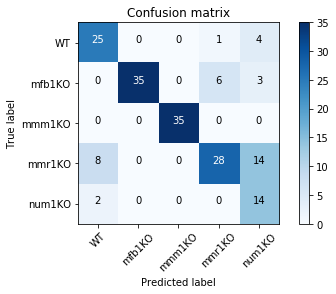

In [30]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

### Test-set eval

In [ ]:
test_learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), test_data)

In [ ]:
# learn.load('YNet_Res_v10.1')

In [ ]:
data = get_data(PATH,SIZE,BATCH_SIZE)

In [ ]:
tx, ty = next(test_batch)
print(ty)

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)

In [ ]:
s1a, s2a = next(batch_)

In [ ]:
batch2x = np.concatenate((s1.cpu().numpy().copy(), s1a.cpu().numpy().copy()), axis = 0)
print(batch2x.shape)

In [ ]:
ims = None
lbls = None

for b in range(0,len(dl)):
    x_, y_ = next(batch_)
    
    x_np = x.cpu().numpy().copy()
    y_np = y.cpu().numpy().copy()
    
    if ims is None:
        ims = x_np
        lbls = y_np
    else:
        ims = np.concatenate((ims, x_np), axis = 0)
        lbls = np.concatenate((lbls, y_np), axis = 0)

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)


plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl)):
    x_, y_ = next(batch_)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C0' , alpha=0.5)
        
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
dl_t = data.test_dl
batch_t = iter(dl_t)

ax = plt.subplot(111)

for b in range(0,len(dl_t)):
    x_, y_ = next(batch_t)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C1' , alpha=0.5)
    
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
# specify which image-index
idx = 60

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
# figure, _ ,_ = plt.imshow(np.sum(xx, axis=0))

# figure.set_size_inches(6,6)
# figure.add_subplot(111)

# figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2)) # not very elegant atm. 
# figure2.set_size_inches(6,6)
print(yy)

In [ ]:
tiff.imshow(data.test_ds[1][0][0,:,:])


In [56]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

350
2228
812


In [33]:
data = get_data(PATH,SIZE,BATCH_SIZE)


 class to index mapping:
 {'01_WT': [0, 0, 'WT'], '01_mfb1KO': [1, 1, 'mfb1KO'], '01_mmm1KO': [2, 2, 'mmm1KO'], '01_mmr1KO': [3, 3, 'mmr1KO'], '01_num1KO': [4, 4, 'num1KO']}

 class to index mapping:
 {'02_WT': [0, 0, 'WT'], '02_mfb1KO': [1, 1, 'mfb1KO'], '02_mmr1KO': [2, 2, 'mmr1KO']}


In [31]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)

In [32]:
print(preds)
print(targs)

[4 0 0 0 0 0 3 4 4 0 3 0 0 0 3 0 0 3 0 0 0 3 3 0 0 4 4 0 3 0 0 4 3 4 0 0 4 0 3 0 0 0 0 0 0 0 4 0 0 0 0 0 0 4
 0 0 0 0 0 3 4 0 4 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 3 0 3 0 0 0
 3 0 3 0 0 0 0 0 4 0 0 3 0 0 0 4 0 0 0 4 3 0 3 0 0 0 0 0 0 0 0 0 0 0 3 3 0 4 3 3 3 4 3 0 0 4 0 3 4 4 4 0 0 0
 3 0 0 0 0 0 0 3 0 0 0 3 0 4 3 0 0 0 3 0 0 3 0 0 0 0 3 0 0 3 0 3 3 0 3 0 0 3 1 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3
 4 3 3 0 4 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 4 3 3 3 4 4 3 4 4 3 0 3 3 0 0 3 3 0 3 4 3 0 0 3 3 3 3 4 3 3 4 4 3
 3 3 1 1 3 3 3 4 3 3 3 0 0 4 3 0 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 0 3 3 3 3 4 3 4 0 4 4 4 3 3 3 4 3 3 3 3 3 4 3
 0 4 4 0 0 3 3 3 0 3 3 4 3 0 3 3 3 3 3 3 4 3 3 4 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 3 3 1 3 4 3 4 3 3 3 3 1 2
 3 0 3 4 3 3 3 1 3 3 3 4 1 3 3 1 3 4 1 3 3 3 3 3 3 3 3 4 0 0 4 4 4 0 4 3 4 0 4 4 4 4 3 0 0 0 4 0 0 0 4 4 4 0
 0 3 0 3 4 4 4 0 4 4 4 0 4 0 0 4 4 3 0 0 0 0 0 3 1 4 3 4 4 4 4 3 4 0 3 3 0 0 4 3 4 3 4 3 4 4 0 0 3 3 3 4 3 3
 4 4 4 0 4 4 4 0 4 

In [59]:
data.classes

['WT', 'mfb1KO', 'mmm1KO', 'mmr1KO', 'num1KO', 'H2O2', 'dnm1KO', 'fzo1KO']

[[ 64  14   4  34   5   0   4  91]
 [118   6   5  23  40  12  96  12]
 [140   6   4  20  21   9  30  54]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


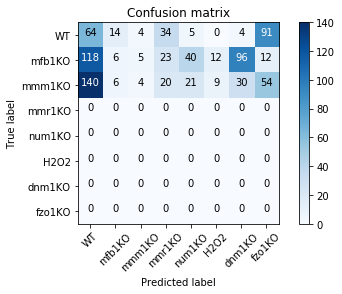

In [61]:
cm = confusion_matrix(targs,preds)
plot_confusion_matrix(cm, data.classes)

In [29]:
_, lbl2idx_, test_lbl2idx_ = ImageClassifierData.prepare_from_path(PATH, val_name='val', bs=64, num_workers=1,
                                                                             test_name='test', test_with_labels=True)

In [45]:
print(lbl2idx_)
print(test_lbl2idx_)

{'01_WT': [0, 0, 'WT'], '01_mfb1KO': [1, 1, 'mfb1KO'], '01_mmm1KO': [2, 2, 'mmm1KO'], '01_mmr1KO': [3, 3, 'mmr1KO'], '01_num1KO': [4, 4, 'num1KO'], '02_WT': [5, 0, 'WT'], '03_H2O2': [6, 5, 'H2O2'], '03_WT': [7, 0, 'WT'], '03_dnm1KO': [8, 6, 'dnm1KO'], '03_fzo1KO': [9, 7, 'fzo1KO']}
{'02_mfb1KO': [0, 0, 'mfb1KO'], '02_mmr1KO': [1, 1, 'mmr1KO'], '02_mmr1KO-mfb1KO': [2, 2, 'mmr1KO-mfb1KO']}


In [32]:
uIdx2uCls = {lbl2idx_[key][1]: lbl2idx_[key][2] for key in lbl2idx_.keys()}
test_uIdx2uCls = {test_lbl2idx_[key][1]: test_lbl2idx_[key][2] for key in test_lbl2idx_.keys()}

In [47]:
print(uIdx2uCls)
print(test_uIdx2uCls)

{0: 'WT', 1: 'mfb1KO', 2: 'mmm1KO', 3: 'mmr1KO', 4: 'num1KO', 5: 'H2O2', 6: 'dnm1KO', 7: 'fzo1KO'}
{0: 'mfb1KO', 1: 'mmr1KO', 2: 'mmr1KO-mfb1KO'}


In [50]:
vrb_preds = [uIdx2uCls[preds[i]] for i, _ in enumerate(preds)]
verb_targs = [test_uIdx2uCls[targs[i]] for i, _ in enumerate(targs)]

In [52]:
print(vrb_preds)
# print(verb_targs)

['WT', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmr1KO', 'WT', 'WT', 'WT', 'fzo1KO', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'WT', 'fzo1KO', 'mmr1KO', 'mfb1KO', 'WT', 'WT', 'WT', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'dnm1KO', 'fzo1KO', 'WT', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'WT', 'num1KO', 'fzo1KO', 'fzo1KO', 'mfb1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'fzo1KO', 'WT', 'mmr1KO', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'WT', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmr1KO', 'mmr1KO', 'WT', 'WT', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmm1KO', 'mmm1KO', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmr1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mfb1KO', 'mmr1KO', 'WT', 'fzo1KO', 'fzo1KO

In [ ]:
test_log_preds[188:220]

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [ ]:
# etc.

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")